Until [afni/afni#156 (🐍 lib_afni1D — Python 2→3)](https://github.com/afni/afni/pull/156) is resolved,

```bash
pip install "git+https://github.com/shnizzedy/afni.git@lib_afni1D/2→3#egg=afni-python&subdirectory=src/python_scripts"
```

to pip-install a Python 3 compatible `afni_python`.

In [1]:
%load_ext autoreload
%autoreload 2

# 🧙 magics

In [2]:
# imports
import git
import glob
import numpy as np
import os
import pandas as pd
import yaml

from string import ascii_lowercase

from compare import Correlation_Matrix
from defaults import motion_list, regressor_list
from subjects import fmriprep_sub, generate_subject_list_for_range

In [3]:
# args
outputs_root = os.path.expanduser("/data3/cnl/fmriprep/AllNewRun")
benchmark = {
    "software": "fmriprep",
    "run": 2
}
this_run = {
    "software": "C-PAC",
    "version": "1.6.2",
    "config": "on_nuisance_new"
}

In [26]:
# Load config
with open('../configs/benchmarks.yml', 'r') as config_file:
    benchmarks = yaml.safe_load(config_file)

with open('../configs/cpac.yml', 'r') as config_file:
    config_settings = yaml.safe_load(config_file)
    
cpac_dir = os.path.abspath(os.path.join(os.getcwd(), *[os.pardir for i in range(3)]))    
n_cpus = 10
pipeline_config_path = os.path.join(cpac_dir, 'dev/docker_data/')
pipeline_file = 'default_pipeline.yml'
pipeline_name = pipeline_file.split('.yml')[0]
tag = git.Repo(search_parent_directories=True).head.object.hexsha[:7]
outputs_dir = os.path.join(config_settings['this_run_outputs'], tag)
benchmark_path = benchmarks[benchmark['software']][benchmark['run']]
if 'this_run' not in vars():
    this_run = {
        "software": "C-PAC",
        "version": tag,
        "config": pipeline_name
    }
sub_list = generate_subject_list_for_range(
    (
        config_settings['subjects']['start'],
        config_settings['subjects']['stop']
    ),
    (
        config_settings['sessions']['start'],
        config_settings['sessions']['stop']
    )
)
var_list = regressor_list + motion_list
if this_run['software'] not in benchmarks:
    benchmarks[this_run['software']] = {}
if this_run['version'] not in benchmarks[this_run['software']]:
    benchmarks[this_run['software']][this_run['version']] = {}
if this_run['config'] not in benchmarks[this_run['software']][this_run['version']]:
    benchmarks[this_run['software']][this_run['version']][this_run['config']] = "/".join([
        tag,
        pipeline_name
    ])
this_run_path = benchmarks[this_run['software']][this_run['version']][this_run['config']]
# with open('../configs/benchmarks.yml', 'w') as config_file:
#     config_file.write(yaml.dump(benchmarks))
corrs = Correlation_Matrix(sub_list, var_list, [
    {"software": "C-PAC", "run_path": os.path.join(outputs_root, this_run_path)},
    {"software": "fmriprep", "run_path": os.path.join(outputs_root, benchmark_path)}
])

Running subject: 0 0 correlation score: nan
Running subject: 0 1 correlation score: nan
Running subject: 0 2 correlation score: nan
Running subject: 0 3 correlation score: nan
Running subject: 0 4 correlation score: nan
Running subject: 0 5 correlation score: nan
Running subject: 0 6 correlation score: nan
Running subject: 0 7 correlation score: nan
Running subject: 0 8 correlation score: nan
Running subject: 0 9 correlation score: nan
Running subject: 1 0 correlation score: 0.9968160282091029
Running subject: 1 1 correlation score: 0.9720365500802093
Running subject: 1 2 correlation score: 0.5449733413804076
Running subject: 1 3 correlation score: -0.9963847487047902
Running subject: 1 4 correlation score: 0.9418403832070215
Running subject: 1 5 correlation score: -0.6346149914755124
Running subject: 1 6 correlation score: 0.6520945757404091
Running subject: 1 7 correlation score: -0.35559452736156355
Running subject: 1 8 correlation score: -0.34921493515658714
Running subject: 1 9 co

Running subject: 21 7 correlation score: 0.1272506335379326
Running subject: 21 8 correlation score: -0.2697274154256146
Running subject: 21 9 correlation score: nan
Running subject: 22 0 correlation score: 0.9928078566153099
Running subject: 22 1 correlation score: 0.9954683111081772
Running subject: 22 2 correlation score: 0.582363481716218
Running subject: 22 3 correlation score: -0.9977096826623124
Running subject: 22 4 correlation score: -0.8413059231600254
Running subject: 22 5 correlation score: 0.5408096070197573
Running subject: 22 6 correlation score: 0.4910681525184615
Running subject: 22 7 correlation score: -0.6316886226218956
Running subject: 22 8 correlation score: 0.13116528451756213
Running subject: 22 9 correlation score: nan
Running subject: 23 0 correlation score: 0.9677208801774436
Running subject: 23 1 correlation score: 0.9912557899487373
Running subject: 23 2 correlation score: 0.09766188458027716
Running subject: 23 3 correlation score: 0.9968498719431732
Runni

Running subject: 50 8 correlation score: nan
Running subject: 50 9 correlation score: nan
Running subject: 51 0 correlation score: nan
Running subject: 51 1 correlation score: nan
Running subject: 51 2 correlation score: nan
Running subject: 51 3 correlation score: nan
Running subject: 51 4 correlation score: nan
Running subject: 51 5 correlation score: nan
Running subject: 51 6 correlation score: nan
Running subject: 51 7 correlation score: nan
Running subject: 51 8 correlation score: nan
Running subject: 51 9 correlation score: nan
Running subject: 52 0 correlation score: nan
Running subject: 52 1 correlation score: nan
Running subject: 52 2 correlation score: nan
Running subject: 52 3 correlation score: nan
Running subject: 52 4 correlation score: nan
Running subject: 52 5 correlation score: nan
Running subject: 52 6 correlation score: nan
Running subject: 52 7 correlation score: nan
Running subject: 52 8 correlation score: nan
Running subject: 52 9 correlation score: nan
Running su

In [31]:
[corrs.data[sub][feat].data for sub in corrs.data for feat in corrs.data[sub]]

[(None,
  0      1425.668667
  1      1425.762758
  2      1423.958210
  3      1421.584404
  4      1421.770963
            ...     
  290    1416.928445
  291    1416.677959
  292    1416.471468
  293    1417.755115
  294    1417.159516
  Name: global_signal, Length: 295, dtype: float64),
 (None,
  0      1388.528517
  1      1390.062783
  2      1389.264112
  3      1388.052077
  4      1388.409542
            ...     
  290    1383.808039
  291    1386.105202
  292    1382.676939
  293    1382.079473
  294    1383.523901
  Name: csf, Length: 295, dtype: float64),
 (None,
  0      1548.458918
  1      1548.694164
  2      1547.237338
  3      1546.904233
  4      1545.885598
            ...     
  290    1536.438374
  291    1538.529737
  292    1538.635963
  293    1538.992025
  294    1538.820543
  Name: white_matter, Length: 295, dtype: float64),
 (None,
  0      0.047774
  1     -0.007591
  2     -0.022667
  3     -0.004974
  4     -0.001657
           ...   
  290   -0.058761
 

In [10]:
corrs.features

['GS',
 'CSF',
 'WM',
 'tCompCor0',
 'aCompCor0',
 'aCompCor1',
 'aCompCor2',
 'aCompCor3',
 'aCompCor4',
 'FD']

---

In [12]:
# Save matrix
import scipy.io as sio

save_path = "/home/jon/CNL/corrs.mat"
sio.savemat(save_path, {'corrs':corrs.corrs})

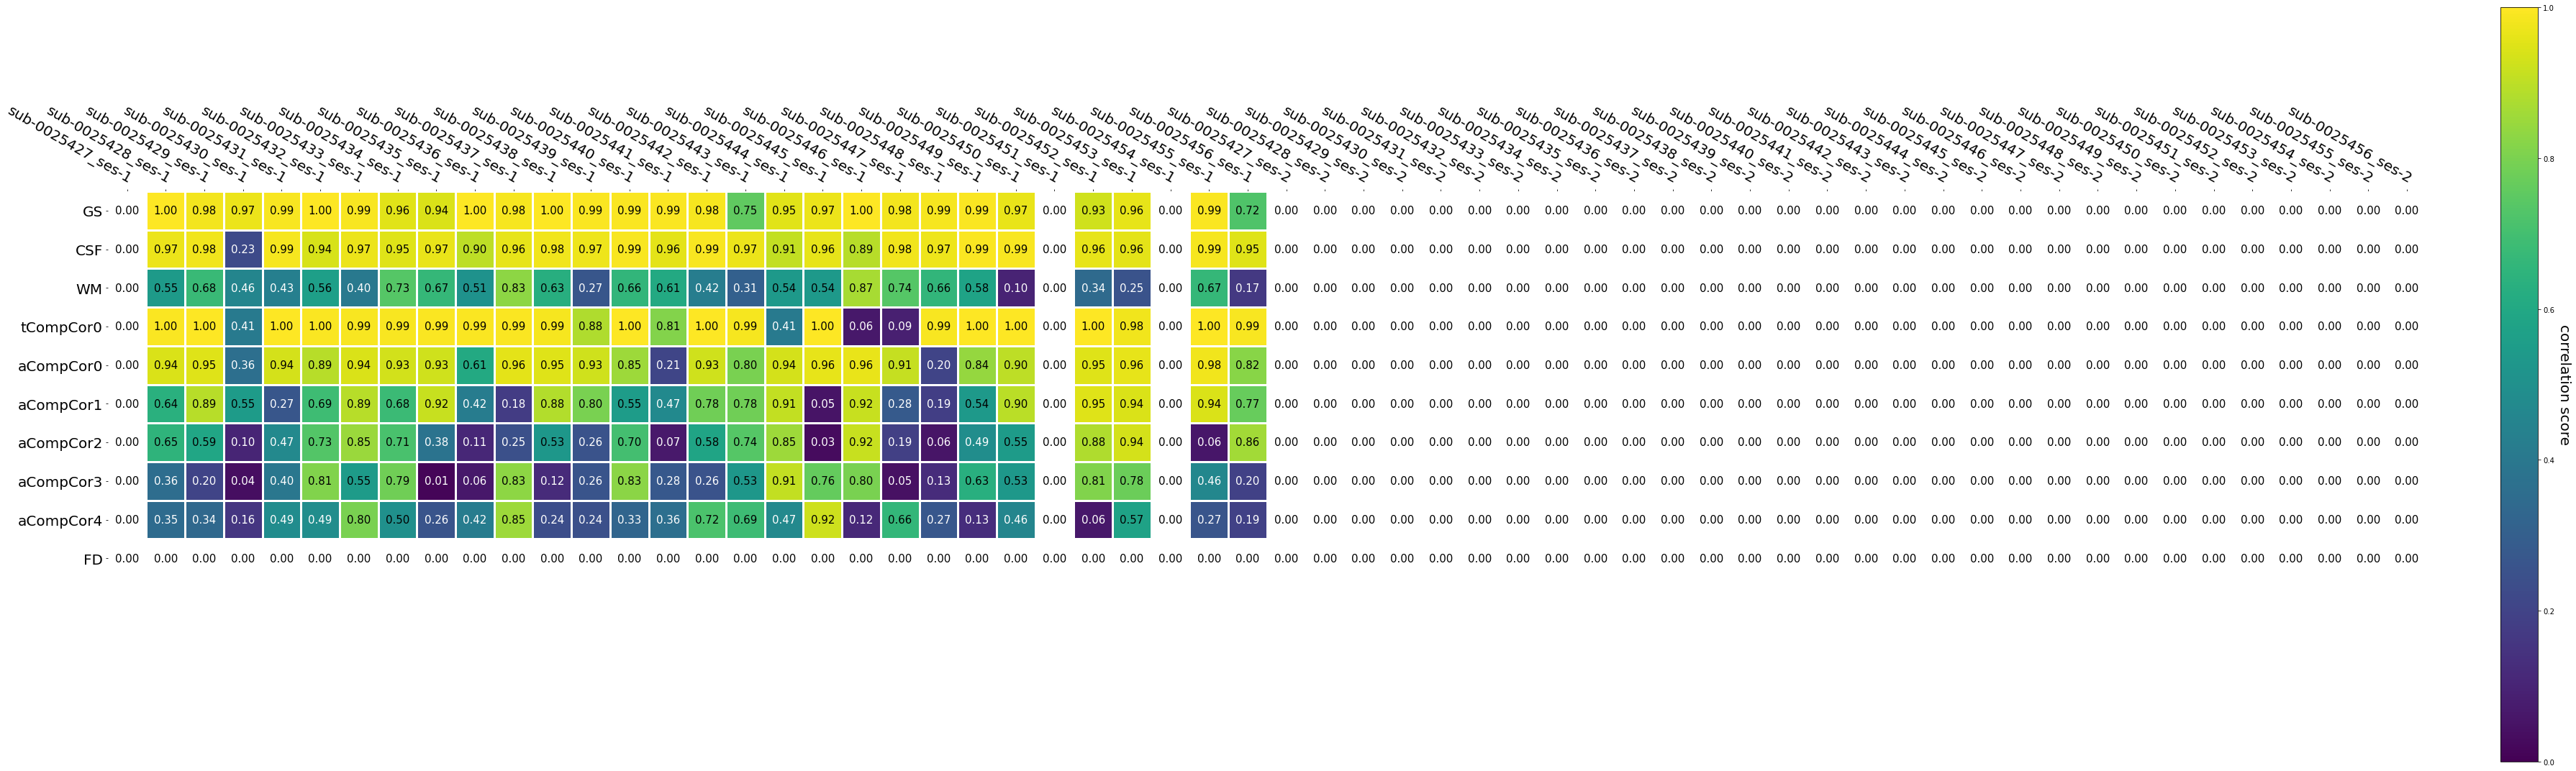

In [24]:
from defaults import motion_list, regressor_list
from heatmaps import generate_heatmap, reshape_corrs
from subjects import generate_subject_list_for_range

generate_heatmap(
    reshape_corrs(save_path),
    regressor_list + motion_list,
    generate_subject_list_for_range(
        (25427, 25456), (1, 2)
    ),
    save_path=False
)

---